In [1]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

In [2]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2021-10-09 11:27:23--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.55.252.111, 2600:1408:9000:887::e59, 2600:1408:9000:89d::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.55.252.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   163MB/s    in 5.4s    

2021-10-09 11:27:28 (144 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [3]:

print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


In [4]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats')
    os.mkdir('/tmp/cats-v-dogs/training/dogs')
    os.mkdir('/tmp/cats-v-dogs/testing/cats')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs')
except OSError:
    pass

In [5]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[-testing_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)


666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [6]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11250
1250
1250


In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [8]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
# Experiment with your own parameters here to really try to drive it to 99.9% accuracy or better
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
# Experiment with your own parameters here to really try to drive it to 99.9% accuracy or better
validation_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [9]:
history = model.fit_generator(train_generator,
                              epochs=15,
                              verbose=1,
                              validation_data=validation_generator)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
172/225 [=====================>........] - ETA: 2:16 - loss: 0.7107 - acc: 0.5752

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

225/225 [==============================] - 614s 3s/step - loss: 0.6921 - acc: 0.5916 - val_loss: 0.6151 - val_acc: 0.6680
Epoch 2/15
225/225 [==============================] - 614s 3s/step - loss: 0.6030 - acc: 0.6742 - val_loss: 0.5718 - val_acc: 0.7104
Epoch 3/15
225/225 [==============================] - 620s 3s/step - loss: 0.5669 - acc: 0.7020 - val_loss: 0.5331 - val_acc: 0.7304
Epoch 4/15
225/225 [==============================] - 627s 3s/step - loss: 0.5428 - acc: 0.7247 - val_loss: 0.5221 - val_acc: 0.7464
Epoch 5/15
225/225 [==============================] - 624s 3s/step - loss: 0.5275 - acc: 0.7357 - val_loss: 0.5270 - val_acc: 0.7296
Epoch 6/15
225/225 [==============================] - 622s 3s/step - loss: 0.5158 - acc: 0.7459 - val_loss: 0.4841 - val_acc: 0.7740
Epoch 7/15
225/225 [==============================] - 624s 3s/step - loss: 0.5008 - acc: 0.7570 - val_loss: 0.4937 - val_acc: 0.7572
Epoch 8/15
225/225 [==============================] - 623s 3s/step - loss: 0.488

<Figure size 432x288 with 0 Axes>

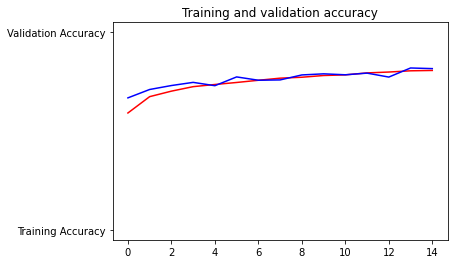

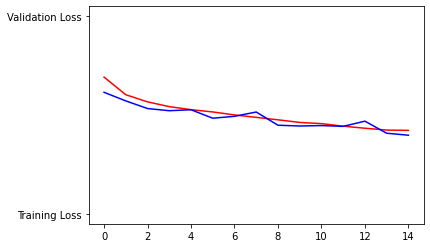

<Figure size 432x288 with 0 Axes>

In [11]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()


# Desired output. Charts with training and validation metrics. No crash :)

In [ ]:
# Here's a codeblock just for fun. You should be able to upload an image here 
# and have it classified without crashing
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")